In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Load CSV
labeled_df = pd.read_csv('train.csv')
unlabeled_df = pd.read_csv('unlabeled.csv')
test_df = pd.read_csv('test.csv')

In [3]:
labeled_df['text'] = labeled_df['text'].astype(str)
unlabeled_df['text'] = unlabeled_df['text'].astype(str)
labeled_df['label'] = labeled_df['label'].map({'non-sexist': 0, 'sexist': 1}).astype('int32')
test_df['text'] = test_df['text'].astype(str)
test_df['label'] = test_df['label'].map({'non-sexist': 0, 'sexist': 1}).astype('int32')

In [4]:
import pickle
with open('tokenizer.pickle', 'rb') as handle:
     tokenizer = pickle.load(handle)

def prepare_inputs(texts, tokenizer, max_len=100):
     texts = texts.fillna('')
     sequences = tokenizer.texts_to_sequences(texts)
     return pad_sequences(sequences, maxlen=max_len, padding='post')

In [5]:
X_train = prepare_inputs(labeled_df['text'], tokenizer)
y_train = labeled_df['label'].values

X_test_final = prepare_inputs(test_df['text'], tokenizer)
y_test_final = test_df['label'].values


In [6]:
model = load_model('baseline-model2.h5')

model.summary()

Model: "model_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 embedding_70 (Embedding)       (None, 100, 200)     6000000     ['input_36[0][0]']               
                                                                                                  
 embedding_71 (Embedding)       (None, 100, 300)     9000000     ['input_36[0][0]']               
                                                                                                  
 concatenate_69 (Concatenate)   (None, 100, 500)     0           ['embedding_70[0][0]',           
                                                                  'embedding_71[0][0]']    


--- Self-training Iteration 1 ---
170/170 [==============================] - 3s 4ms/step
Confident predictions: Sexist=43, Non-sexist=1261
Iteration 1 - Pseudo-labeled: Sexist=43, Non-sexist=43
Training set size: 4742
Validation set size: 1186
Epoch 1/20
75/75 [==============================] - 3s 28ms/step - loss: 0.4574 - accuracy: 0.8254 - val_loss: 0.3885 - val_accuracy: 0.8744 - lr: 2.5000e-05
Epoch 2/20
75/75 [==============================] - 2s 24ms/step - loss: 0.4479 - accuracy: 0.8345 - val_loss: 0.3901 - val_accuracy: 0.8718 - lr: 2.5000e-05
Epoch 3/20
75/75 [==============================] - 2s 25ms/step - loss: 0.4493 - accuracy: 0.8290 - val_loss: 0.3870 - val_accuracy: 0.8735 - lr: 2.5000e-05
Epoch 4/20
75/75 [==============================] - 2s 25ms/step - loss: 0.4519 - accuracy: 0.8347 - val_loss: 0.3865 - val_accuracy: 0.8752 - lr: 2.5000e-05
Epoch 5/20
75/75 [==============================] - 2s 24ms/step - loss: 0.4368 - accuracy: 0.8349 - val_loss: 0.3843 - val

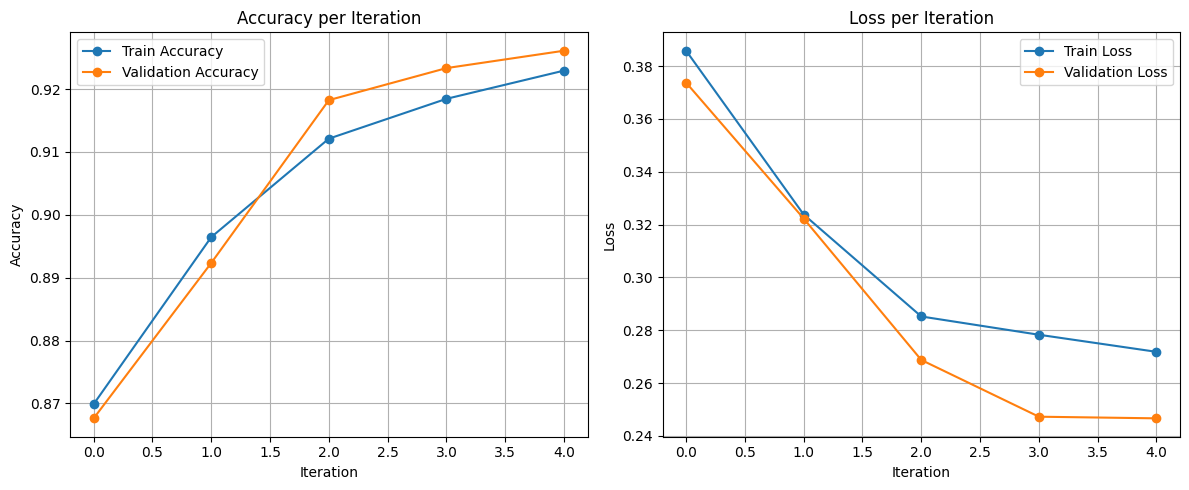


🧾 Pseudo-labeled samples per iteration (label=1, label=0):
Iteration 1: Sexist=43, Non-sexist=43
Iteration 2: Sexist=332, Non-sexist=332
Iteration 3: Sexist=281, Non-sexist=281
Iteration 4: Sexist=171, Non-sexist=171
Iteration 5: Sexist=7, Non-sexist=7
72/72 [==============================] - 0s 4ms/step - loss: 0.2807 - accuracy: 0.9184

🎯 Final Evaluation — Accuracy: 0.9184, Loss: 0.2807


In [ ]:
iterations = 5
confidence_threshold_high = 0.9
confidence_threshold_low = 0.1 
batch_size = 64
epochs = 20

# Logs
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []
pseudo_labeled_counts = []
confident_data = []
iteration_data = []
use_balanced_pseudolabeling = True

for iteration in range(iterations):
    print(f"\n--- Self-training Iteration {iteration + 1} ---")

    # Check if there's enough unlabeled data to proceed
    if len(unlabeled_df) == 0:
        print("No unlabeled data left. Stopping early.")
        break

    # Predict on unlabeled data
    X_unlabeled = prepare_inputs(unlabeled_df['text'], tokenizer)
    preds = model.predict(X_unlabeled, batch_size=batch_size, verbose=1).flatten()

    # Identify confident predictions based on two thresholds
    label1_confident_indices = np.where(preds >= confidence_threshold_high)[0]  # Sexist (label=1)
    label0_confident_indices = np.where(preds <= confidence_threshold_low)[0]   # Non-sexist (label=0)

    print(f"Confident predictions: Sexist={len(label1_confident_indices)}, Non-sexist={len(label0_confident_indices)}")

    # Balance pseudo-labels
    if use_balanced_pseudolabeling:
        num_to_select = min(len(label1_confident_indices), len(label0_confident_indices))
        if num_to_select == 0:
            print("Not enough balanced confident samples. Stopping early.")
            break
        selected_label1_indices = label1_confident_indices[:num_to_select]
        selected_label0_indices = label0_confident_indices[:num_to_select]
        selected_indices = np.concatenate([selected_label1_indices, selected_label0_indices])
        selected_labels = np.array([1] * num_to_select + [0] * num_to_select)
    else:
        if len(label1_confident_indices) + len(label0_confident_indices) == 0:
            print("No confident samples found. Stopping early.")
            break
        selected_indices = np.concatenate([label1_confident_indices, label0_confident_indices])
        selected_labels = np.array([1] * len(label1_confident_indices) + [0] * len(label0_confident_indices))

    # Exceed available data in the unlabeled DataFrame
    if max(selected_indices) >= len(unlabeled_df):
        print(f"Selected indices are out-of-bounds. Stopping early.")
        break

    selected_texts = unlabeled_df.iloc[selected_indices]['text'].values
    selected_confidences = np.concatenate([preds[selected_label1_indices], preds[selected_label0_indices]])

    # Logs
    count_label1 = sum(selected_labels == 1)
    count_label0 = sum(selected_labels == 0)
    pseudo_labeled_counts.append((count_label1, count_label0))
    confident_data.append((selected_texts, selected_labels))
    print(f"Iteration {iteration + 1} - Pseudo-labeled: Sexist={count_label1}, Non-sexist={count_label0}")
    iteration_data.extend(zip(selected_texts, selected_labels, selected_confidences))

    # Prepare pseudo-labeled data
    X_pseudo = prepare_inputs(pd.Series(selected_texts), tokenizer)
    y_pseudo = selected_labels.astype('int32')

    # Add to training set
    X_train = np.concatenate([X_train, X_pseudo], axis=0)
    y_train = np.concatenate([y_train, y_pseudo], axis=0)

    print(f"New dataset set size: {len(X_train)}")

    num_sexist = np.sum(y_train == 1)
    num_non_sexist = np.sum(y_train == 0)

    # Print the counts
    print(f"Number of sexist posts: {num_sexist}")
    print(f"Number of non-sexist posts: {num_non_sexist}")

    # Remove from unlabeled set
    unlabeled_df = unlabeled_df.drop(index=unlabeled_df.index[selected_indices]).reset_index(drop=True)

    # Split train into sub-train and validation
    X_train_sub, X_val, y_train_sub, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, shuffle=True
    )

    print(f"Training set size: {len(X_train_sub)}")
    print(f"Validation set size: {len(X_val)}")

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)
    ]

    history = model.fit(
        X_train_sub, y_train_sub,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    train_accuracies.append(history.history['accuracy'][-1])
    val_accuracies.append(history.history['val_accuracy'][-1])
    train_losses.append(history.history['loss'][-1])
    val_losses.append(history.history['val_loss'][-1])

    test_loss, test_accuracy = model.evaluate(X_test_final, y_test_final, verbose=0)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


print("\nSelf-training complete")


# 📈 Plot metrics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Accuracy per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Loss per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 🔢 Print pseudo-label stats
print("\n🧾 Pseudo-labeled samples per iteration (label=1, label=0):")
for i, (s1, s0) in enumerate(pseudo_labeled_counts, 1):
    print(f"Iteration {i}: Sexist={s1}, Non-sexist={s0}")

# 🧪 Final evaluation on clean test set
final_loss, final_accuracy = model.evaluate(X_test_final, y_test_final, verbose=1)
print(f"\n🎯 Final Evaluation — Accuracy: {final_accuracy:.4f}, Loss: {final_loss:.4f}")

In [17]:
print("\n🧾 Pseudo-labeled samples per iteration (label=1 = Sexist, label=0 = Non-sexist):")
print(f"{'Iteration':<10} {'Sexist (1)':<15} {'Non-Sexist (0)':<17} {'Total':<10}")
print("-" * 55)
for i, (s1, s0) in enumerate(pseudo_labeled_counts, 1):
    total = s1 + s0
    print(f"{i:<10} {s1:<15} {s0:<17} {total:<10}")


🧾 Pseudo-labeled samples per iteration (label=1 = Sexist, label=0 = Non-sexist):
Iteration  Sexist (1)      Non-Sexist (0)    Total     
-------------------------------------------------------
1          43              43                86        
2          332             332               664       
3          281             281               562       
4          171             171               342       
5          7               7                 14        


In [18]:
# 🔢 Print Pseudo-label Counts
print("\n🧾 Pseudo-labeled samples per iteration (label=1, label=0):")
for i, (s1, s0) in enumerate(pseudo_labeled_counts, 1):
    print(f"Iteration {i}: Sexist={s1}, Non-sexist={s0}")

# Display confident samples from each iteration
print("\n📝 Confident Samples from Each Iteration:")
for iteration, confident_samples in enumerate(confident_data, 1):
    print(f"\nIteration {iteration} - Confident Samples:")
    for sample, label in zip(confident_samples[0], confident_samples[1]):
        print(f"Text: {sample} -> Pseudo-label: {'Sexist' if label == 1 else 'Non-Sexist'}")
    print("\n" + "-"*50 + "\n")


🧾 Pseudo-labeled samples per iteration (label=1, label=0):
Iteration 1: Sexist=43, Non-sexist=43
Iteration 2: Sexist=332, Non-sexist=332
Iteration 3: Sexist=281, Non-sexist=281
Iteration 4: Sexist=171, Non-sexist=171
Iteration 5: Sexist=7, Non-sexist=7

📝 Confident Samples from Each Iteration:

Iteration 1 - Confident Samples:
Text: [user] ugly talentless you referring to yourself -> Pseudo-label: Sexist
Text: [user] it is funny how you call them talented women you are fandom calls jisoo talentless and least popular  -> Pseudo-label: Sexist
Text: [user] embarrassing hagsoo stans got nothing to defend their talentless hag hence replying in corny shit laugh my ass off  -> Pseudo-label: Sexist
Text: [user] are you that blind calling her talentless shame on you  -> Pseudo-label: Sexist
Text: she is not jisoo no ones upset neposoo in not in the vid cos no one cares about her but her fans stay in your lane talentless hag stan -> Pseudo-label: Sexist
Text: [user] this is the real comparison 

In [19]:
test_loss, test_accuracy = model.evaluate(X_test_final, y_test_final)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

72/72 [==============================] - 0s 4ms/step - loss: 0.2807 - accuracy: 0.9184
Test Loss: 0.2807, Test Accuracy: 0.9184


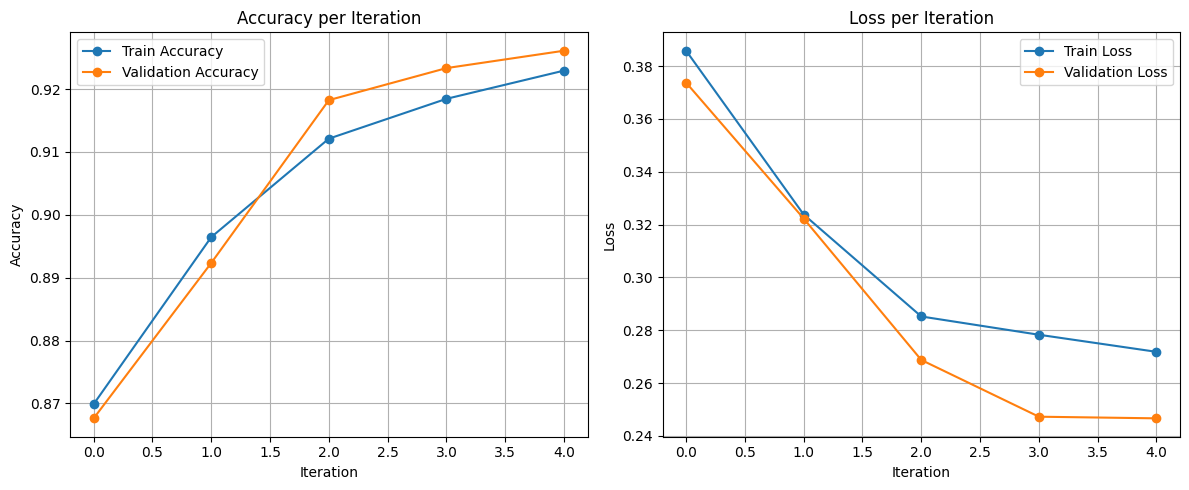

In [20]:
# 📊 Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Accuracy per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Loss per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

72/72 [==============================] - 0s 3ms/step
Accuracy: 0.9183852566915314
Precision: 0.9010375099760575
Recall: 0.9479429051217464
F1 Score: 0.9238952536824877

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.89      0.91      1088
           1       0.90      0.95      0.92      1191

    accuracy                           0.92      2279
   macro avg       0.92      0.92      0.92      2279
weighted avg       0.92      0.92      0.92      2279



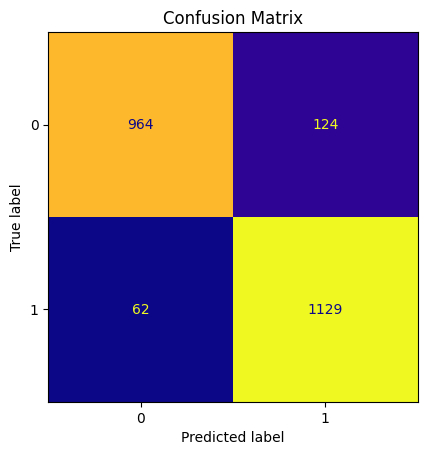

72/72 [==============================] - 0s 3ms/step


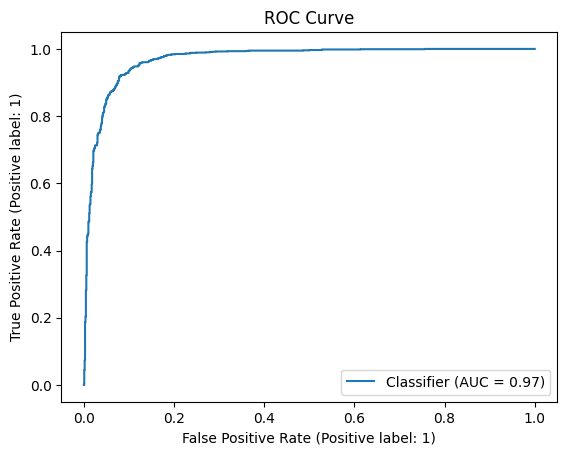

72/72 [==============================] - 0s 3ms/step
ROC-AUC Score: 0.9696621721736554


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay

# Predictions
preds = (model.predict(X_test_final) > 0.5).astype(int)

# Metrics
print("Accuracy:", accuracy_score(y_test_final, preds))
print("Precision:", precision_score(y_test_final, preds))
print("Recall:", recall_score(y_test_final, preds))
print("F1 Score:", f1_score(y_test_final, preds))
print("\nClassification Report:\n", classification_report(y_test_final, preds))

# Confusion Matrix
cm = confusion_matrix(y_test_final, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='plasma', colorbar=False)
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(y_test_final, model.predict(X_test_final))
plt.title("ROC Curve")
plt.show()

# AUC Score
print("ROC-AUC Score:", roc_auc_score(y_test_final, model.predict(X_test_final)))

In [22]:
iteration_df = pd.DataFrame(iteration_data, columns=['text', 'label', 'confidence'])
iteration_df.to_csv('pseudo_labeled_samples.csv', index=False)

In [14]:
# Get probabilities and predictions
y_probs = model.predict(X_test_final)
y_preds = (y_probs > 0.5).astype(int).reshape(-1)
y_probs = y_probs.reshape(-1)
y_val = np.array(y_test_final).reshape(-1)

reverse_word_index = {v: k for k, v in tokenizer.word_index.items()}

def sequence_to_text(sequence):
    return ' '.join([reverse_word_index.get(idx, '[UNK]') for idx in sequence if idx != 0])

# Convert all validation sequences back to text
X_val_texts = [sequence_to_text(seq) for seq in X_test_final]

# Create DataFrame
results_df = pd.DataFrame({
    'text': X_val_texts,               # list of original texts
    'true_label': y_val,
    'predicted_label': y_preds,
    'probability': y_probs
})

72/72 [==============================] - 0s 3ms/step


In [15]:
false_positives = results_df[(results_df['predicted_label'] == 1) & (results_df['true_label'] == 0)]
#false_positives[['text', 'probability']].to_csv("false_positives_texts.csv", index=False)

# False Negatives: predicted non-sexist (0), actually sexist (1)
false_negatives = results_df[(results_df['predicted_label'] == 0) & (results_df['true_label'] == 1)]
#false_negatives[['text', 'probability']].to_csv("false_negatives_texts.csv", index=False)

In [16]:
# Display False Positives
print("\n--- False Positives (predicted sexist, actually non-sexist) ---")
for i, row in false_positives.iterrows():
    print(f"[P: {row['probability']:.2f}] {row['text']}")

# Display False Negatives
print("\n--- False Negatives (predicted non-sexist, actually sexist) ---")
for i, row in false_negatives.iterrows():
    print(f"[P: {row['probability']:.2f}] {row['text']}")



--- False Positives (predicted sexist, actually non-sexist) ---
[P: 0.75] if i get more fans my boyfriend will join me you will get videos photos of my pussy mouth filled with cum my tits ass face covered with cum and shots of him fucking my face pussy
[P: 0.93] user be a whore
[P: 0.93] at what point did i slut shame anyone i said that was not how i got into uni
[P: 0.93] no i think most women could find a guy and i do not mean some homeless guy with aids if they wanted to regardless but it would have to be reasonable like a guy who might be a little short maybe a little overweight has a kid something like that
[P: 0.86] user what the fuck rubbish you do not look anywhere near fifty and nothing like a prostitute
[P: 0.70] the mere identity as a trophy wife is insulting there are many situations in which those involved do actually have feelings for one another think of the era of arranged marriages love is something that can exist in places where you never thought it would
[P: 0.67] u

In [23]:
results_df.to_csv("model_predictions.csv", index=False)
print("Saved predictions to model_predictions.csv")

Saved predictions to model_predictions.csv
